In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

In [ ]:
# load the Boston dataset
data = load_boston()
X, y, columns = data['data'], data['target'], data['feature_names']

In [ ]:
# normalize 
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1,1))


In [ ]:
# ADALINE implementation
class Adaline:
    def __init__(self, eta=0.01, tol=1e-6, max_epochs=1000):
        self.eta = eta
        self.tol = tol
        self.max_epochs = max_epochs

    def predict(self, X):
        return X @ self.w

    def fit(self, X, y):
        N, m = X.shape
        epochs = 0
        w = np.random.rand(m)
        error_epoch = []
        ediff = np.Inf

        while((epochs < self.max_epochs) & (ediff > self.tol)):
            xseq = np.arange(N)
            np.random.shuffle(xseq)
            ei2 = 0
            for iseq in xseq:
                erro = (y[iseq] - X[iseq, :] @ w)
                w = w + self.eta * erro * X[iseq,:]
                ei2 = ei2 + erro ** 2

            ei2 = ei2 / N
            error_epoch.append(ei2)
            epochs = epochs + 1

            if(epochs > 1):
                ediff = np.abs(ediff - ei2)
            else:
                ediff = ei2

        self.w = w
        return w, error_epoch

    def fit_predict(self, X_train, y_train, X_test):
        self.fit(X_train, y_train)
        return self.predict(X_test)




In [ ]:
# split training data randomly
def train_test_split(X, y, ratio=0.8):
    N = len(y)
    x_rand = np.arange(N)
    np.random.shuffle(x_rand)
    i_split = int(np.floor(ratio * N))

    x_train, x_test = x_rand[:i_split], x_rand[i_split:]
    return X[x_train,:], y[x_train], X[x_test,:], y[x_test]

X_train, y_train, X_test, y_test = train_test_split(X_scaled, y_scaled)

In [ ]:
# Train the model
adaline = Adaline(tol=1e-6) 
w, error = adaline.fit(X_train, y_train)

# plot the training error
fig, ax = plt.subplots()
ax.plot(error)

In [ ]:
def augment(x): 
    return np.hstack((-np.ones((len(x), 1)), x.reshape(-1,1)))

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # prediction
    y_test_pred = adaline.predict(X_test)
    y_train_pred = adaline.predict(X_train)
    y_test_aug = augment(y_test)
    y_train_aug = augment(y_train)

    # R2 score
    r2_test, r2_train = r2_score(y_test, y_test_pred), r2_score(y_train, y_train_pred)
   
    fig, ax = plt.subplots(2,2, figsize=(12, 10))
    adareg = Adaline()
    
    # actual vs prediction - training
    ax[0,0].scatter(y_test, y_test_pred, color='k')
    ax[0,0].plot(y_test, adareg.fit_predict(y_test_aug, y_test_pred, y_test_aug), 'r-')
    ax[0,0].set_xlabel('real')
    ax[0,0].set_ylabel('prediction')
    ax[0,0].set_title(f'Test: $R^2$: {r2_test}')

    # actual vs prediction - test
    ax[0,1].scatter(y_train, y_train_pred, color='k')
    ax[0,1].plot(y_train, adareg.fit_predict(y_train_aug, y_train_pred, y_train_aug), 'r-')
    ax[0,1].set_xlabel('real')
    ax[0,1].set_ylabel('prediction')
    ax[0,1].set_title(f'Train: $R^2$: {r2_train}')

    # values - training
    ax[1,1].plot(y_train, 'b')
    ax[1,1].plot(y_train_pred, 'r')
    ax[1,1].set_xlabel('Index')
    ax[1,1].set_ylabel('y')

    # values - test
    ax[1,0].plot(y_test, 'b')
    ax[1,0].plot(y_test_pred, 'r')
    ax[1,0].set_xlabel('Index')
    ax[1,0].set_ylabel('y')


In [ ]:
# Evalute the model
evaluate_model(adaline, X_train, y_train, X_test, y_test)


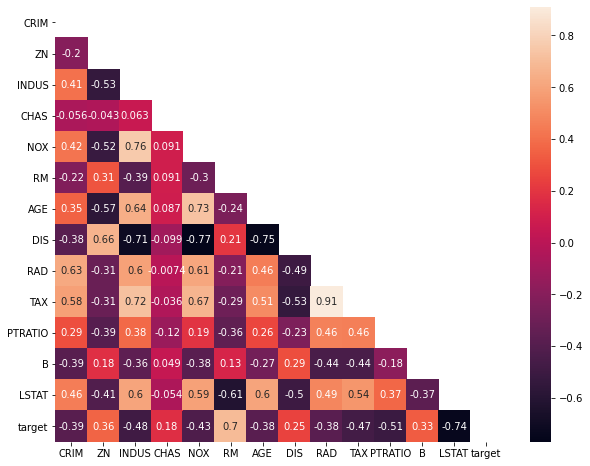

In [196]:
# plot the correlation matrix
def to_pandas(X, y, columns):
    data_pd = pd.DataFrame(X, columns=columns)
    data_pd['target'] = y
    return data_pd

def plot_correlation(X, y, columns):
    fig, ax = plt.subplots(figsize=(10,8))
    corr = to_pandas(X,y,columns).corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(corr, mask=mask, annot=True, ax=ax)
    fig.show()

plot_correlation(X_scaled,y_scaled,columns)

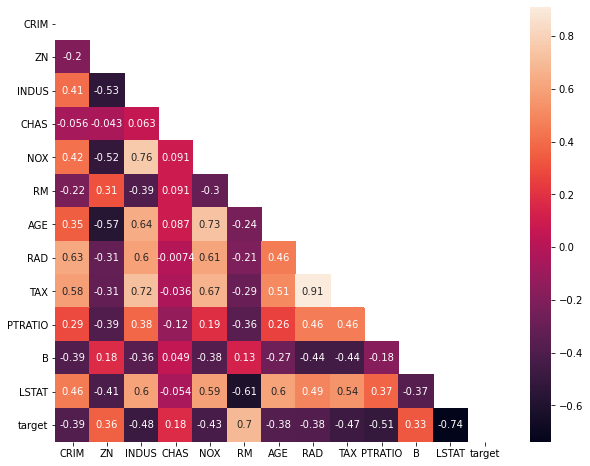

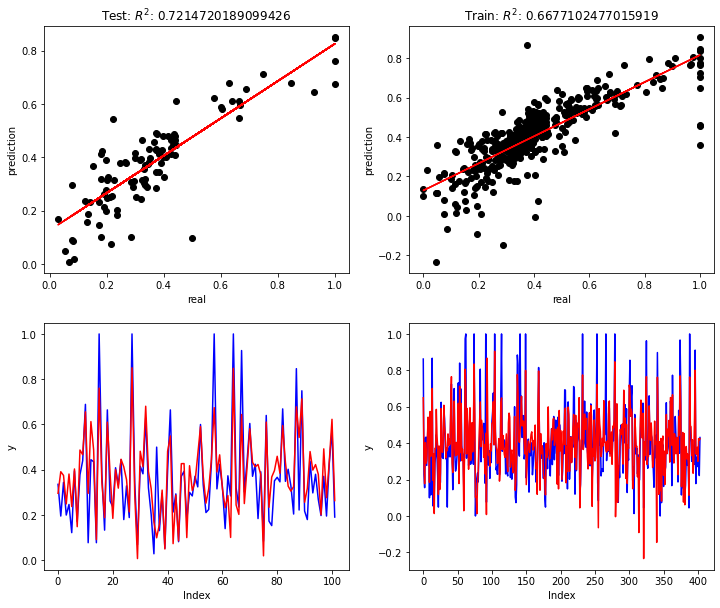

In [198]:
# remove high correlated variables
# DIS and INDUS are highly correlated with each other (-0.7)
# Since INDUS has a higher correlation with the target, DIS will be removed
# Train the model
cols_to_remove = ['DIS']
mask = ~np.isin(columns, cols_to_remove)
cols_to_include = np.arange(len(columns))[mask]

X_train_r = X_train[:, cols_to_include]
X_test_r = X_test[:, cols_to_include]

adaline = Adaline(tol=1e-6)  
#X_train_r, y_train_r, X_test_r, y_test_r = train_test_split(X_reduced, y_scaled)
w, error = adaline.fit(X_train_r, y_train)
evaluate_model(adaline, X_train_r, y_train, X_test_r, y_test)


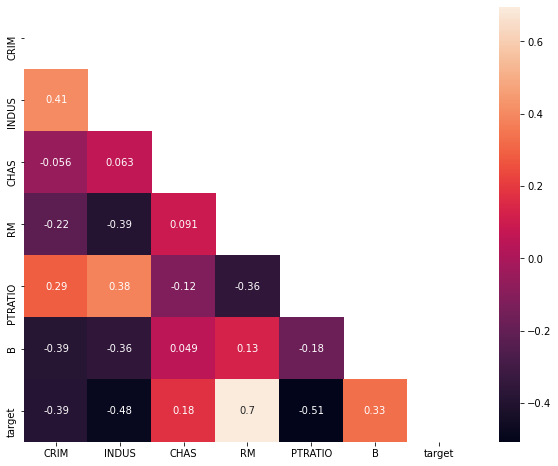

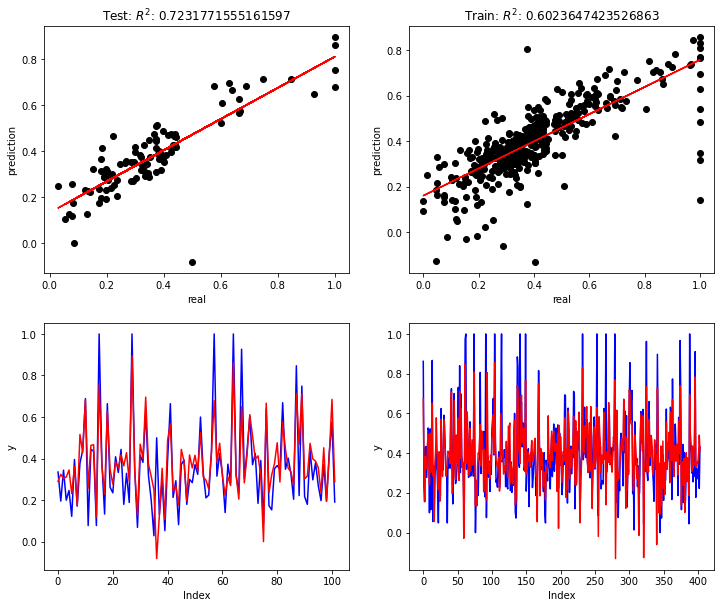

In [202]:
# remove high correlated variables
# NOX and INDUS are highly correlated with each other (0.75)
# Since INDUS has a higher correlation with the target, NO will be removed
# Train the model
cols_to_remove = ['DIS', 'NOX', 'TAX', 'RAD', 'LSTAT', 'AGE', 'ZN']
mask = ~np.isin(columns, cols_to_remove)
cols_to_include = np.arange(len(columns))[mask]

X_train_r = X_train[:, cols_to_include]
X_test_r = X_test[:, cols_to_include]

plot_correlation(X_scaled[:, cols_to_include],y_scaled,columns[cols_to_include])

adaline = Adaline(tol=1e-6)  
w, error = adaline.fit(X_train_r, y_train)
evaluate_model(adaline, X_train_r, y_train, X_test_r, y_test)


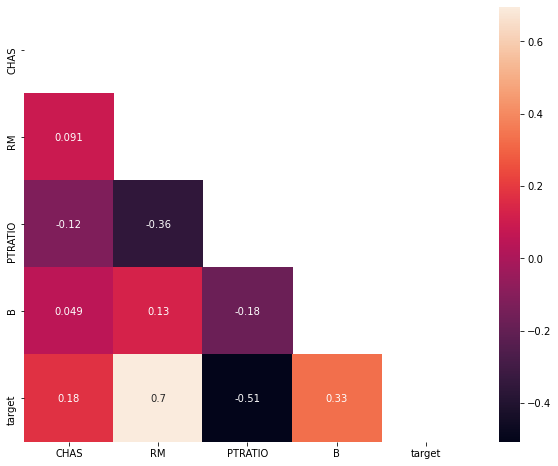

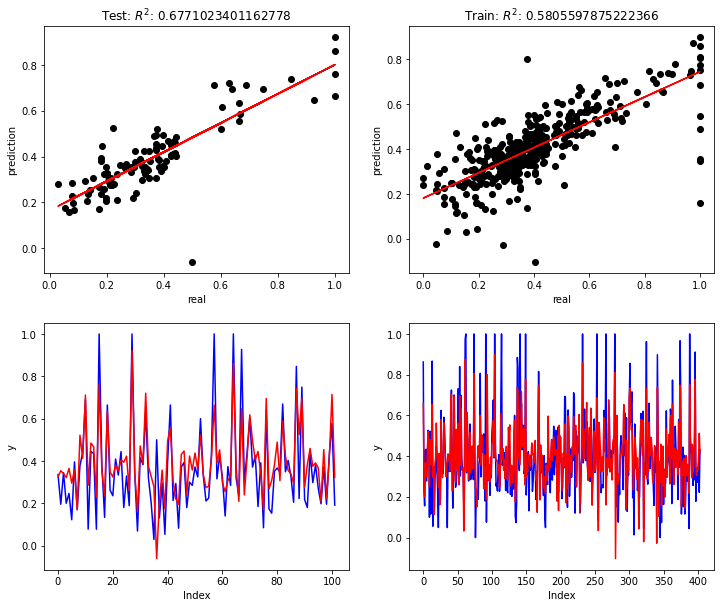

In [222]:
high_corr_pairs = []
cols_to_remove = []
for c1 in columns:
  for c2 in columns:
    if (c1 != c2) & (c1 not in cols_to_remove) & ((corr[c1][c2]) > 0.5) & (c1 != 'target') & (c2 != 'target'):
      high_corr_pairs.append((c1, c2))
      cols_to_remove.append(c1)

high_corr_pairs = pd.DataFrame(high_corr_pairs, columns=['p1', 'p2'])
high_corr_pairs['target_corr_p1'] = high_corr_pairs['p1'].apply(lambda x: np.abs(corr[x]['target']))
high_corr_pairs['target_corr_p2'] = high_corr_pairs['p2'].apply(lambda x: np.abs(corr[x]['target']))

cols_to_remove = list(set(cols_to_remove))

mask = ~np.isin(columns, cols_to_remove)
cols_to_include = np.arange(len(columns))[mask]

X_train_r = X_train[:, cols_to_include]
X_test_r = X_test[:, cols_to_include]

plot_correlation(X_scaled[:, cols_to_include],y_scaled,columns[cols_to_include])

adaline = Adaline(tol=1e-6)  
w, error = adaline.fit(X_train_r, y_train)
evaluate_model(adaline, X_train_r, y_train, X_test_r, y_test)
